In [30]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from keras.utils import normalize, to_categorical
from sklearn.metrics import confusion_matrix, roc_curve, auc

import sys
sys.path.insert(0, '/home/btannenw/Desktop/ML/dihiggsMLProject/')
from rectangularCuts.rectangularAnalyzer import sequentialOneDimAnalyzer
from utils.commonFunctions import *

In [2]:
testingFraction = 0.3

In [4]:
# Load models
#loadedBDT = pickle.load(open('models/grid-model.allVars.pkl', 'rb'))
#loadedBDT = pickle.load(open('models/grid-model.allVars.pkl', 'rb'))
loadedBDT = pickle.load(open('models/model.noJetVars.pkl', 'rb'))
loadedRectangular = pickle.load(open('../rectangularCuts/models/rectangularModel.normSignal_qcd2M.pkl', 'rb'))
loadedNN = pickle.load( open('../NeuralNetworking/models/allVars_100-50-50.pkl', 'rb'))

Using TensorFlow backend.


In [24]:
# *** 0. Rectangular Analysis
hh_csv, qcd_csv = importDatasets()
variables_rect = loadedRectangular.variables
variables_bdt = loadedBDT.feature_names
variables_nn = hh_csv.columns

# *** 1. Make training and testing data
data_train, data_test, labels_train, labels_test = makeTestTrainSamplesWithUserVariables(hh_csv, qcd_csv,variables_nn, testingFraction)

# *** 2. Split hh and qcd from testing data [ALL]
data_signal_test, labels_signal_test, data_bkg_test, labels_bkg_test = returnTestSamplesSplitIntoSignalAndBackground(data_test, labels_test)

# *** 3. Subset for rectangular
data_test_rect = data_test.copy()
data_test_rect = data_test_rect[ variables_rect ]
data_signal_test_rect, labels_signal_test_rect, data_bkg_test_rect, labels_bkg_test_rect = returnTestSamplesSplitIntoSignalAndBackground(data_test_rect, labels_test)

# *** 4. Subset for BDT
data_test_bdt = data_test.copy()
data_test_bdt = data_test_bdt[ variables_bdt ]
data_signal_test_bdt, labels_signal_test_bdt, data_bkg_test_bdt, labels_bkg_test_bdt = returnTestSamplesSplitIntoSignalAndBackground(data_test_bdt, labels_test)


N_sig = 78876 , N_bkg = 116481
195357 rows of total data with  195357 labels [Train+Test]
136749 rows of training data with  136749 labels [Train]
58608 rows of testing data with  58608 labels [Test]


In [25]:
# calculate BDT sig

# *** A. Make predictions 
sig_DMatrix = xgb.DMatrix(data_signal_test_bdt, label=labels_signal_test)
preds_sig   = loadedBDT.predict(sig_DMatrix)
bkg_DMatrix = xgb.DMatrix(data_bkg_test_bdt, label=labels_bkg_test)
preds_bkg   = loadedBDT.predict(bkg_DMatrix)

sig_pred_isSignal   = [x[1] for x in preds_sig]
bkg_pred_isSignal  = [x[1] for x in preds_bkg]

# *** F. Calculate significance 
returnBestCutValue('BDT', sig_pred_isSignal.copy(), bkg_pred_isSignal.copy(), _minBackground=4e5)


/home/btannenw/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


23615 34993
nSig = 668.99736 , nBkg = 424191.36 with significance = 1.0271727625110683 for BDT score > 0.8253823162992533


(1.0271727625110683, 0.8253823162992533)

In [26]:
lumiscale_qcd = getLumiScaleFactor(testingFraction, False)
np.sqrt(418226/lumiscale_qcd)/(418226/lumiscale_qcd)

0.07268165046455086

In [27]:
# calculate rectangular significance
# *** A. Use previously calculated const. efficiency cuts on testing data from BDT
cuts = loadedRectangular.dictOfCutsByEfficiency
loadedRectangular.setReducedData(data_signal_test_rect, data_bkg_test_rect)
loadedRectangular.calculateYieldsAfterCuts(0.90) 
loadedRectangular.calculateYieldsAfterCuts(0.85) 
loadedRectangular.calculateYieldsAfterCuts(0.80) 

iteration 3, signal has 23615 rows
iteration 3, background has 34993 rows
Iteration 3 chose variable hh_mass with N_signal = 21301 (31564.1) and N_background = 26925 (26925)
Iteration 2 chose variable h2_mass with N_signal = 19690 (29176.9) and N_background = 22481 (22481)
iteration 1, signal has 19690 rows
iteration 1, background has 22481 rows
Iteration 1 chose variable h1_mass with N_signal = 19080 (28273.0) and N_background = 19556 (19556)
S/sqrt(B) = 202.18
iteration 3, signal has 23615 rows
iteration 3, background has 34993 rows
Iteration 3 chose variable deltaR(h1, h2) with N_signal = 21418 (31737.5) and N_background = 34042 (34042)
Iteration 2 chose variable deltaR(h2 jets) with N_signal = 19306 (28607.9) and N_background = 27278 (27278)
iteration 1, signal has 19306 rows
iteration 1, background has 27278 rows
Iteration 1 chose variable deltaR(h1 jets) with N_signal = 18099 (26819.3) and N_background = 25062 (25062)
S/sqrt(B) = 169.41
iteration 6, signal has 23615 rows
iteratio

In [9]:
# *** B. Calculate rectangular significance
nSig_raw = 14618
nBkg_raw = 8839

hh_lumiScale = getLumiScaleFactor(testingFraction, True)
qcd_lumiScale = getLumiScaleFactor(testingFraction, False)
nSig_lumi = nSig_raw*hh_lumiScale
nBkg_lumi = nBkg_raw*qcd_lumiScale

print(hh_lumiScale, qcd_lumiScale)

print('nSig = {0} , nBkg = {1} with significance = {2} for RectangularAnalysis'.format(nSig_lumi, nBkg_lumi, nSig_lumi/np.sqrt(nBkg_lumi)) )

0.24719999999999998 2209.33
nSig = 3613.5696 , nBkg = 19528267.87 with significance = 0.8177198910906328 for RectangularAnalysis


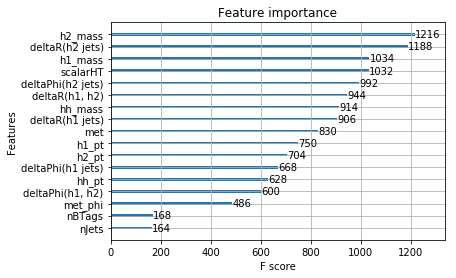

In [38]:
xgb.plot_importance(loadedBDT)

In [16]:
loadedBDT.get_score(importance_type='gain')

{'h1_mass': 192.4161179396334,
 'deltaR(h1, h2)': 60.740497400821745,
 'scalarHT': 12.444672676131576,
 'deltaR(h1 jets)': 28.081530578097315,
 'deltaR(h2 jets)': 16.576185789877876,
 'h1_pt': 11.243520819721306,
 'hh_mass': 12.309460899868933,
 'met': 5.250126367525427,
 'h2_pt': 6.589460291555555,
 'met_phi': 3.173257614529412,
 'h2_mass': 53.38637703393965,
 'nBTags': 7.018158566250001,
 'deltaPhi(h1, h2)': 3.701743830441177,
 'deltaPhi(h1 jets)': 3.7490017909459445,
 'deltaPhi(h2 jets)': 4.738214097271186,
 'nJets': 5.461235996941176,
 'hh_pt': 19.534171620888895}

34993/34993 [==============================] - 1s 26us/step
[0.5919447204608824, 0.6698708534240723] [0.3398865382621551, 0.8767182230949402]


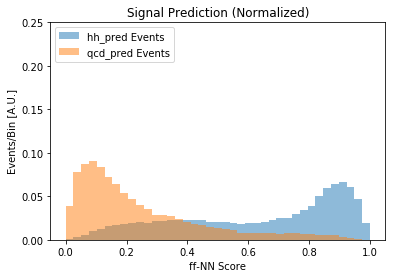

23615 34993
nSig = [1107.7032] , nBkg = [419772.7] with significance = [1.70968584] for ff-NN score > [0.89834154]


(array([1.70968584]), array([0.89834154], dtype=float32))

In [34]:
# evaluate NN model

data_signal_test = normalize(data_signal_test, axis=1)
data_bkg_test = normalize(data_bkg_test, axis=1)

score_hh = loadedNN.evaluate(data_signal_test, labels_signal_test)
score_qcd = loadedNN.evaluate(data_bkg_test, labels_bkg_test)
print(score_hh, score_qcd)
pred_hh = loadedNN.predict(data_signal_test)
pred_qcd = loadedNN.predict(data_bkg_test)

_nBins = 40
predictionResults = {'hh_pred':pred_hh, 'qcd_pred':pred_qcd}
compareManyHistograms( predictionResults, ['hh_pred', 'qcd_pred'], 2, 'Signal Prediction', 'ff-NN Score', 0, 1, _nBins, _yMax = 5, _normed=True, _savePlot=False )

# *** 4. Get best cut value for ff-NN assuming some minimal amount of signal
returnBestCutValue('ff-NN', pred_hh.copy(), pred_qcd.copy(), _minBackground=3e5, _testingFraction=testingFraction)

In [ ]:
# ROC curve and AUC
bdt_test_ROC = data_test_bdt.copy()
bdt_test_ROC = bdt_test_ROC.drop('isSignal', axis=1)

y_pred = loadedBDT.predict(bdt_test_ROC).ravel()
bdt_falsePositiveRate, bdt_truePositiveRate, thresholds = roc_curve(data_labels_test, y_pred)
bdt_auc = auc(bdt_falsePositiveRate, bdt_truePositiveRate)